In [1]:
import os
import numpy as np
from mne.io import read_raw_egi

In [2]:
pth = r'C:\Users\swps\Dropbox\DANE\CAT N170\EEG'
fls = os.listdir(pth)
fls

['CAT102 20130521 1855002.raw',
 'CAT110 20131108 2040002.raw',
 'CAT113 20131124 1839002.raw',
 'CAT311 20131209 1929002.raw',
 'CAT312 20131209 2056002.raw',
 'ICAw 2013.12.19 17.12.50.960.mat',
 'ICAw_first_test.mat',
 'SET']

In [3]:
# wybieramy tylko pliki kończące się na .raw
fls = [f for f in fls if f.endswith('.raw')]
fls

['CAT102 20130521 1855002.raw',
 'CAT110 20131108 2040002.raw',
 'CAT113 20131124 1839002.raw',
 'CAT311 20131209 1929002.raw',
 'CAT312 20131209 2056002.raw']

In [4]:
cd $pth

C:\Users\swps\Dropbox\DANE\CAT N170\EEG


In [5]:
# wczytujemy jeden plik
eeg = read_raw_egi(fls[0], preload=True)

Reading EGI header from CAT102 20130521 1855002.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
    Found multiple events at the same time sample. Cannot create trigger channel.
Reading 0 ... 209198  =      0.000 ...   836.792 secs...


In [6]:
# tworzymy z kanałów DIN macierz wydarzeń i dodajemy do eeg
from mypy import events
eeg = events.din2event(eeg)

In [7]:
# sprawdzamy niepowtarzające się wydarzenia
np.unique(eeg.info['events'][:, 2])

array([  1,   2,  36,  40,  44,  52,  56,  60,  64, 128, 192])

In [8]:
# filtrowanie
eeg.filter(1, None)

High-pass filtering at 1 Hz


<RawEGI  |  CAT102 20130521 1855002.raw, n_channels x n_times : 65 x 209199 (836.8 sec)>

Using matplotlib backend: Qt4Agg


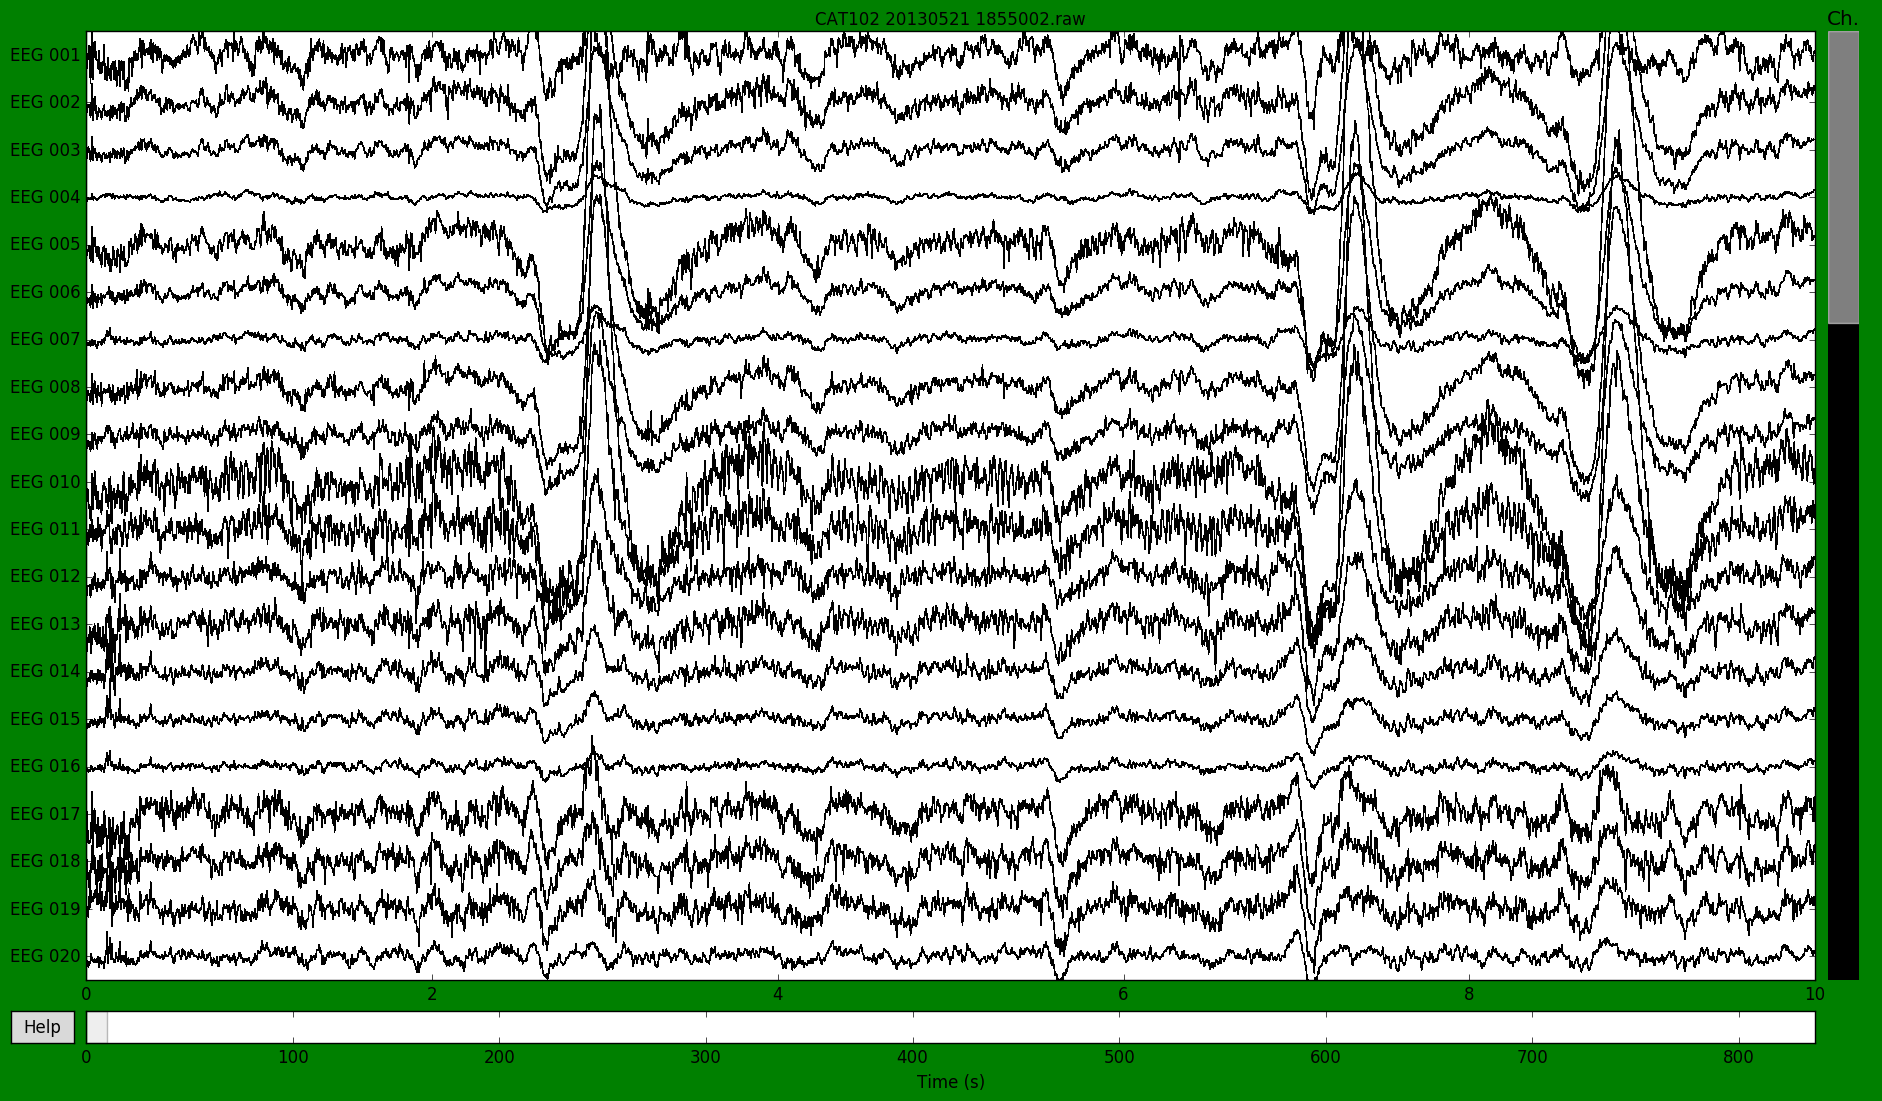

In [9]:
# włączamy tryb interaktywny i zerkamy na dane
%matplotlib
eeg.plot(bgcolor='g')

In [10]:
# poprawiamy nazwy kanałów (EEG 001 -> E1)
events.correct_egi_channel_names(eeg)

In [11]:
# ustawiamy montaż
import mne
mntg = mne.channels.read_montage('GSN-HydroCel-65_1.0')
eeg.set_montage(mntg)

In [12]:
# epokujemy
ev_id = {'face': 52, 'car': 36}
epoki = mne.Epochs(eeg, events=eeg.info['events'], 
                   event_id=ev_id, tmin=-0.25,
                   tmax=0.5, preload=True)

137 matching events found
Applying baseline correction (mode: mean)
Adding average EEG reference projection.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 137 events and 188 original time points ...
0 bad epochs dropped


Using matplotlib backend: Qt4Agg


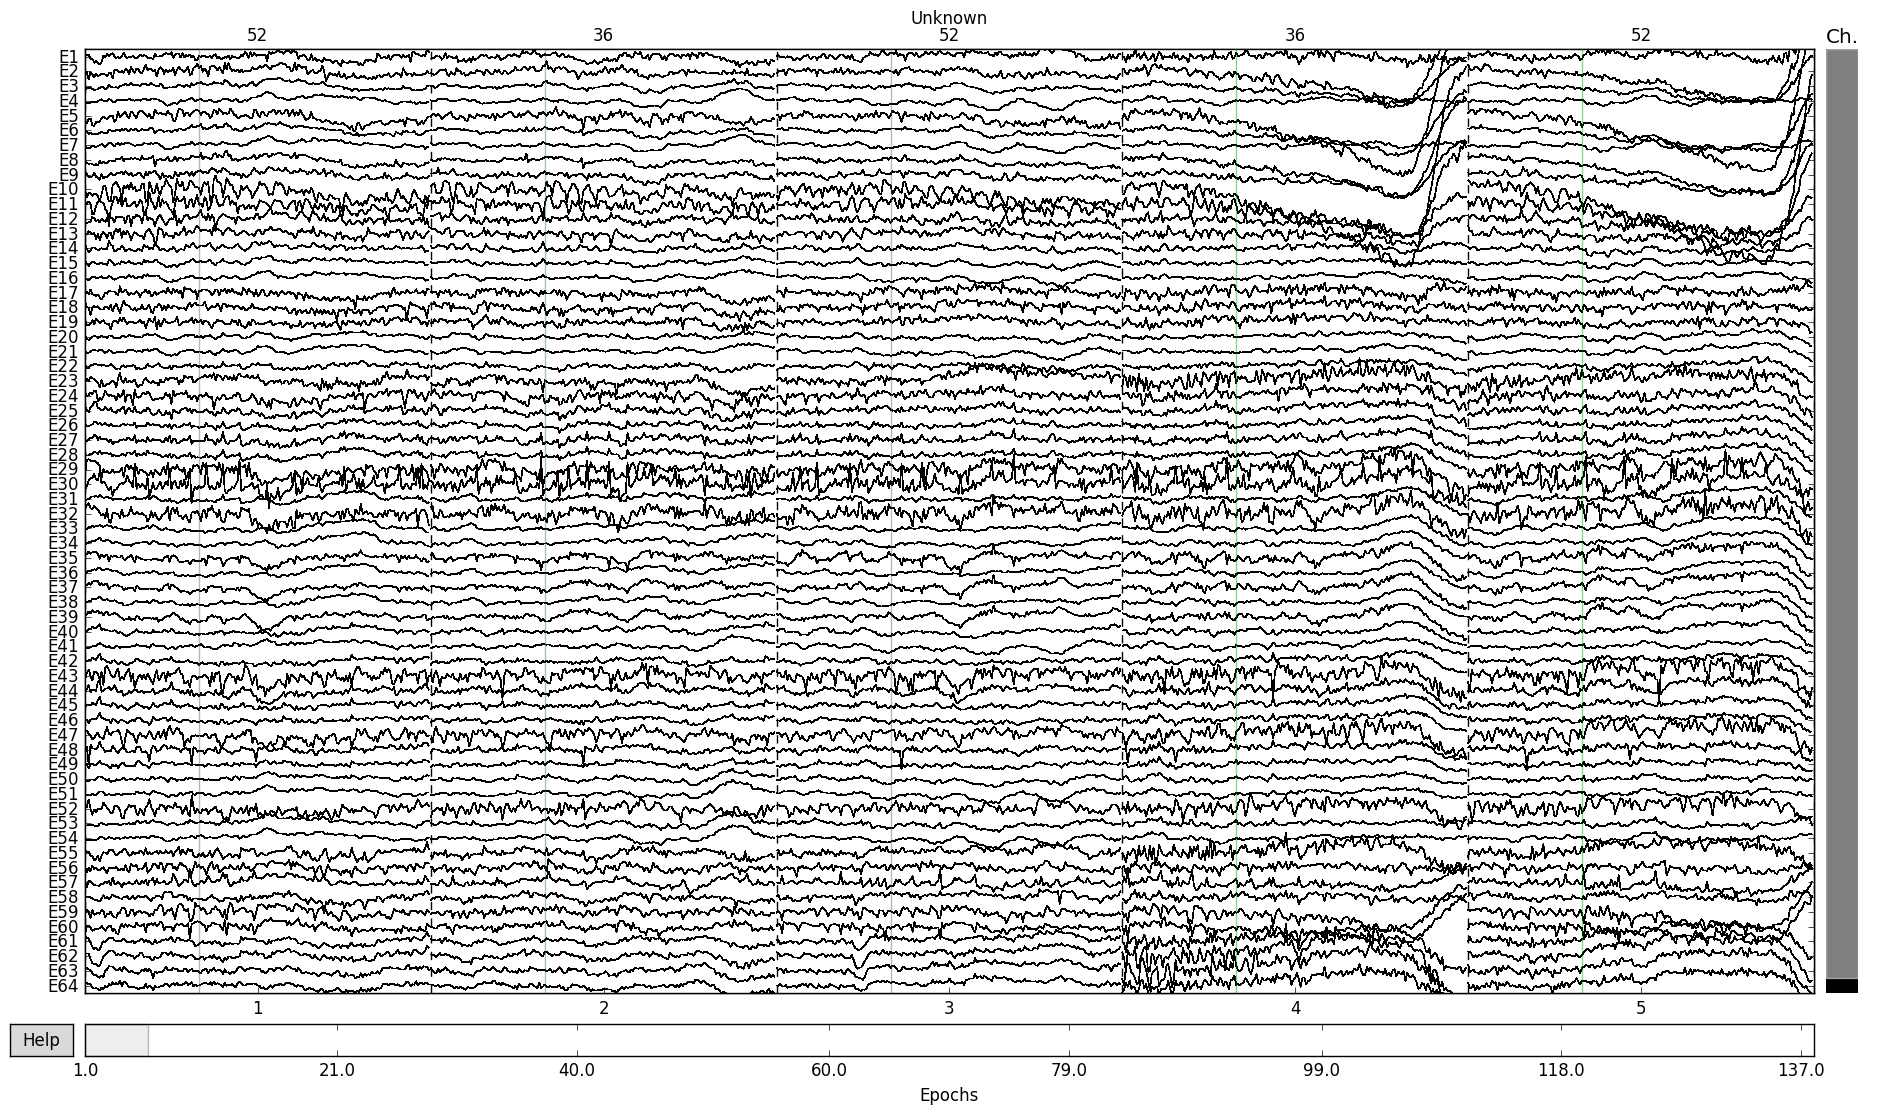

Dropped 0 epochs
Channels marked as bad: []


In [13]:
# przeglądamy epoki
%matplotlib
epoki.plot(n_channels=64, scalings={'eeg': 'auto'}, n_epochs=5)

In [14]:
# tworzymy uśrednioną odpowiedź na wszystkie bodźce
erpy = epoki.average()

In [15]:
# sprawdzamy który kanał to E47
erpy.ch_names.index('E47')

46

In [16]:
# zobaczmy sobie reakcję na danym kanale
erpy.plot(picks=[46]);

In [15]:
erpy.plot_topomap(0.15);

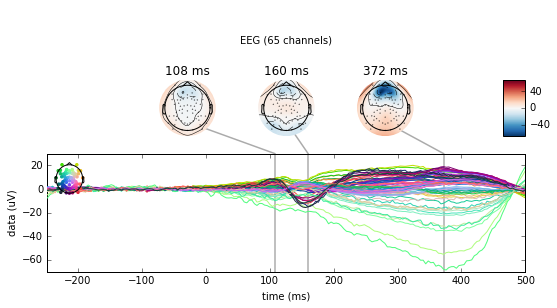

In [17]:
%matplotlib inline
erpy.plot_joint();

In [17]:
epoki['face'].plot_image(picks=[43], sigma=3)

In [19]:
# oddzielne erpy dla warunków
erpy_sam = epoki['car'].average()
erpy_twa = epoki['face'].average()

W sytuacji powyżej (szczególnie gdyby warunków było więcj) można skorzystać z dictionary comprehensions (tak jak list comprehensions ale dają w efekcie słownik):
```python
erpy = {w: erpoki[w].average() for w in ['car', 'face']}
# teraz `erpy` to słownik:
erpy['car'] # daje nam ERPa na warunek 'car'
```

## Plotowanie

In [20]:
import matplotlib.pyplot as plt

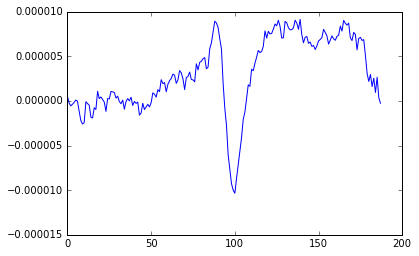

In [21]:
# najpierw prosty wykres
%matplotlib inline
plt.plot(erpy_twa.data[46, :])

Zauważcie, że nie ma sensownych informacji na osi x (czas). Dodamy je teraz - czas dla każdej próbki znajdziemy w `epoki.times` (ale także np. w `erpy_twa.times`)

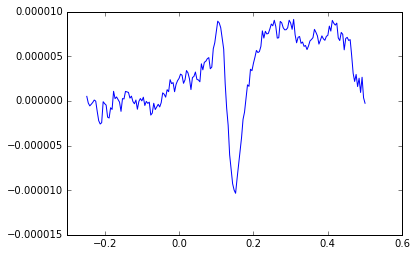

In [23]:
plt.plot(epoki.times, erpy_twa.data[46, :])

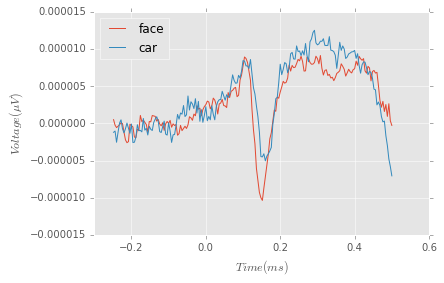

In [29]:
# zróbmy nieco ładniejszy wykres, z jednym i drugim warunkiem

# skorzystamy ze stylu ggplot'a (znany pakiet graficzny do R'a)
plt.style.use('ggplot')

# rysujemy erpy_twa, a następnie erpy_sam, dodajemy label, aby
# legenda wiedziała jak opisać te linie
plt.plot(erpy_twa.times, erpy_twa.data[46, :], label='face')
plt.plot(erpy_sam.times, erpy_sam.data[46, :], label='car')

# dodajemy legendę
plt.legend(loc='best')

# dodajemy opis osi x i y (znaki $ dodaję aby tekst był
# interpretowany przez LaTeX a zatem "\mu" było zamieniane
# w specjalny znak - literę Greckiego alfabetu)
plt.xlabel('$Time (ms)$')
plt.ylabel(r'$Voltage (\mu V)$')